<h1 align = "center"> 问题分类解决方案 </h1>

---
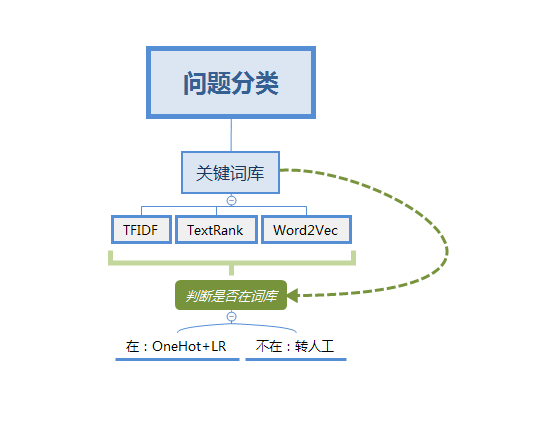

In [1]:
import re
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import jieba
import jieba.analyse

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import text
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from pipe import *

In [2]:
df = pd.read_excel('./corpus.xlsx').fillna('')
question_name = list(filter(lambda x: '问题' in x, df.columns))
df = df[['分类名称'] + question_name]
df['x'] = df.apply(lambda x: ''.join(x[1:]), 1)
df['y'] = df['分类名称']
data = df[['x', 'y']]

In [3]:
class MyNLP(object):
    def __init__(self, USER_DICT=None, STOP_WORDS_PATH=None):
        jieba.load_userdict(USER_DICT)
        self.STOP_WORDS_PATH = STOP_WORDS_PATH

    def get_pure_corpus(self, corpus):
        segment = jieba.cut(re.sub('[^0-9a-zA-Z\u4e00-\u9fa5]+', ' ', corpus))
        return ' '.join(filter(lambda x: x not in self.stop_words, segment))

    def get_key_words(self, sentence,
                      allowPOS=['v', 'vg', 'vd', 'vn', 'n', 'nr', 'nr1', 'nr2', 'nrj', 'nrf', 'ns', 'nsf', 'nt', 'nz',
                                'nl', 'ng'], topK=300):
        params = {'sentence': sentence, 'topK': topK, 'allowPOS': allowPOS}
        key_words = set(jieba.analyse.tfidf(**params) + jieba.analyse.textrank(**params))
        return list(key_words)

    @property
    def stop_words(self):
        with open(self.STOP_WORDS_PATH) as f:
            stop_words = [line.strip() for line in f.readlines()] + [' ']
        return stop_words

In [4]:
x = '为什么阿里蚂蚁花呗、京东白条就不用上报征信？为什么花呗、京东白条就不上报征信？'
USER_DICT = '/DATA/UserDict/finWordDict.txt'
STOP_WORDS_PATH = "/DATA/UserDict/stop_words.txt"
mynlp = MyNLP(USER_DICT, STOP_WORDS_PATH)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Dumping model to file cache /tmp/jieba.cache
Dump cache file failed.
Traceback (most recent call last):
  File "/algor/yuanjie/intel/intelpython3/lib/python3.6/site-packages/jieba/__init__.py", line 152, in initialize
    _replace_file(fpath, cache_file)
PermissionError: [Errno 1] Operation not permitted: '/tmp/tmptu1quofq' -> '/tmp/jieba.cache'
Loading model cost 1.440 seconds.
Prefix dict has been built succesfully.


In [5]:
key_words = mynlp.get_key_words(' '.join(data.x), topK=200)
oneHot = text.CountVectorizer()
oneHot.fit(key_words)

get_features = lambda x: oneHot.transform([' '.join(list(set(jieba.cut(x))))]).toarray()[0]

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [6]:
data['xx'] = data.x.apply(get_features)
feat_name = []
for i in range(len(key_words)):
    feat_name.append('xx_%s' %i)
    data['xx_%s' %i] = data.xx.apply(lambda x: x[i])
    
le = LabelEncoder().fit(data.y)
data['yy'] = le.transform(data.y)

In [7]:
X = data[feat_name].values
y = data.yy.values
lr = LogisticRegression()
lr.fit(X, y)
print(classification_report(y, lr.predict(X)))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

             precision    recall  f1-score   support

          0       0.99      1.00      0.99        98
          1       1.00      1.00      1.00        23
          2       1.00      1.00      1.00        38
          3       1.00      1.00      1.00         4
          4       1.00      1.00      1.00         3
          5       1.00      0.95      0.97        20
          6       1.00      1.00      1.00         3
          7       1.00      1.00      1.00         8
          8       1.00      1.00      1.00         5
          9       1.00      1.00      1.00         2
         10       1.00      1.00      1.00         2
         11       1.00      1.00      1.00        23
         12       1.00      1.00      1.00         2
         13       1.00      1.00      1.00         6
         14       1.00      1.00      1.00         6
         15       1.00      1.00      1.00        38
         16       1.00      1.00      1.00        10
         17       1.00      1.00      1.00   

In [8]:
@Pipe
def get_class(x):
    words = set(jieba.cut(x))
    if words.intersection(key_words):
        return le.classes_[lr.predict(get_features(x).reshape(1, -1))]
    else:
        print("请转人工客服！")

In [9]:
'上传信用卡不会泄露我信息么' | get_class
'一个傻子在苏宁' | get_class
'易付宝' | get_class
'企业' | get_class
'账户' | get_class
'银行' | get_class
'添利盈未到能提不' | get_class


array(['信用卡还款'], dtype=object)

array(['礼品卡'], dtype=object)

array(['易付宝账户'], dtype=object)

array(['企业易付宝'], dtype=object)

array(['任性付'], dtype=object)

array(['任性付'], dtype=object)

请转人工客服！
